In [1]:
# Customer Purchase Behavior Analysis & Sales Prediction
# Notebook by: <Your Name>
# Run this notebook from project root (so data/ path works)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# display settings
pd.set_option('display.max_columns', 50)
sns.set(style='whitegrid')


In [2]:
df = pd.read_csv("synthetic_retail.csv", parse_dates=['InvoiceDate'])
print("Rows:", len(df))
df.head()


Rows: 50000


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Description,Sales
0,C1972,INV133553,2024-03-17,2,88.60,Product_100,177.20
1,C2686,INV109427,2024-01-19,3,160.10,Product_8,480.30
2,C2967,INV100199,2024-01-07,3,142.09,Product_131,426.27
3,C1259,INV112447,2024-01-09,2,48.46,Product_44,96.92
4,C2140,INV139489,2024-03-01,1,55.56,Product_107,55.56


In [3]:
# Drop rows without CustomerID (synthetic data has IDs)
df = df[df['CustomerID'].notna()].copy()

# Ensure positive quantities and prices
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)].copy()

# Sales column already exists in synthetic; if not: df['Sales'] = df['Quantity']*df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M').astype(str)

print("After clean:", df.shape)


After clean: (50000, 9)


In [4]:
total_revenue = df['Sales'].sum()
num_customers = df['CustomerID'].nunique()
tx_count = df['InvoiceNo'].nunique()
avg_order_value = df.groupby('InvoiceNo')['Sales'].sum().mean()

print(f"Total revenue: ₹{total_revenue:,.2f}")
print("Unique customers:", num_customers)
print("Total invoices:", tx_count)
print(f"Avg Order Value: ₹{avg_order_value:,.2f}")


Total revenue: ₹15,339,769.15
Unique customers: 2000
Total invoices: 50000
Avg Order Value: ₹306.80


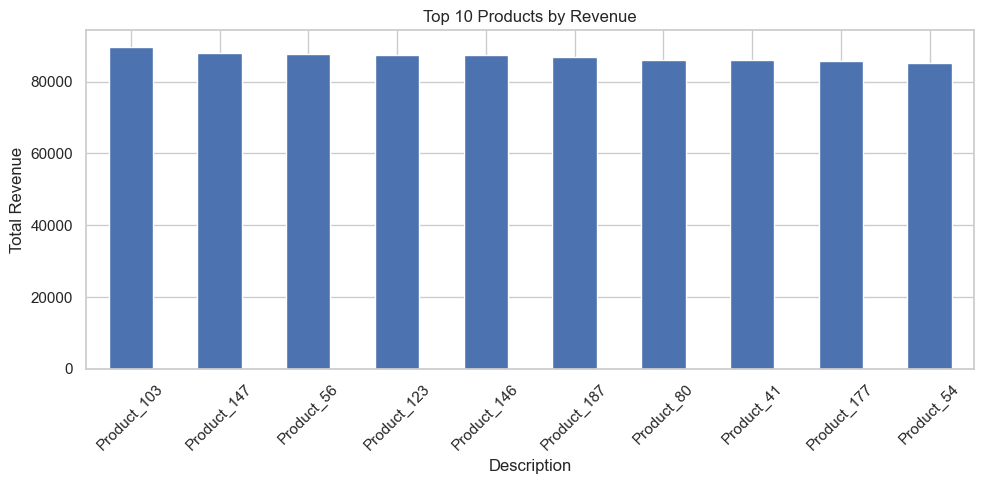

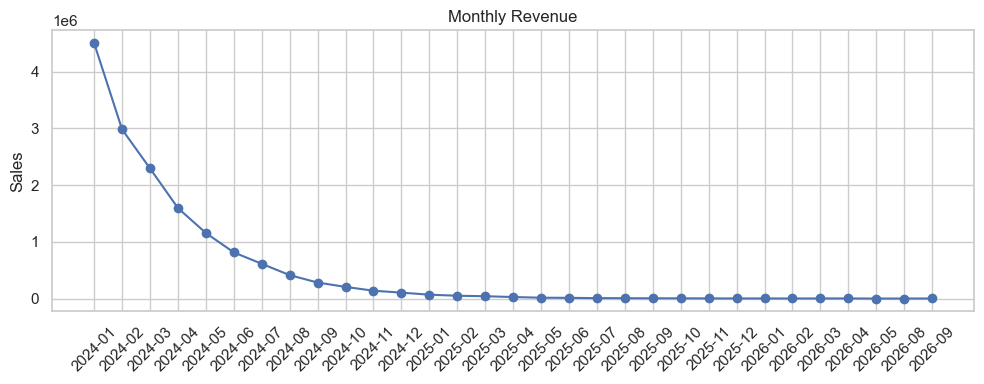

In [16]:
# Top 10 products by total revenue
product_revenue = df.groupby('Description')['Sales'].sum().sort_values(ascending=False)

top10_products = product_revenue.head(10)

plt.figure(figsize=(10,5))
top10_products.plot(kind='bar')
plt.title("Top 10 Products by Revenue")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()

# Save image (optional for GitHub)
plt.savefig("top_products_revenue.png", dpi=300)

plt.show()

top10_products

# Plot monthly revenue
monthly = df.groupby('YearMonth')['Sales'].sum().reset_index()
plt.figure(figsize=(10,4))
plt.plot(monthly['YearMonth'], monthly['Sales'], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue")
plt.ylabel("Sales")
plt.tight_layout()
plt.savefig("revenue_trend.png", bbox_inches="tight")



In [6]:
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index().rename(columns={'InvoiceDate':'FirstPurchase'})
df = df.merge(first_purchase, on='CustomerID', how='left')
df['IsReturning'] = df['InvoiceDate'] > df['FirstPurchase']

# customers with >1 invoice are returning at some point
cust_invoice_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo':'InvoiceCount'})
cust_invoice_counts['IsReturningCustomer'] = cust_invoice_counts['InvoiceCount'] > 1
cust_invoice_counts['InvoiceCount'].value_counts().head()


InvoiceCount
25    169
23    167
24    151
28    148
22    147
Name: count, dtype: int64

In [7]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Sales': 'sum'
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,C1000,769,21,5094.63
1,C1001,804,27,8116.25
2,C1002,584,27,8110.09
3,C1003,759,23,5343.11
4,C1004,671,27,7334.12


In [8]:
# Simple quintile scoring
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)  # lower recency => higher score
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
# Example segment: top customers where R>=4 & F>=4 & M>=4
rfm['Segment'] = 'Low-Value'
rfm.loc[(rfm['R_score']>=4) & (rfm['F_score']>=4) & (rfm['M_score']>=4), 'Segment'] = 'Top'
rfm.loc[(rfm['R_score']>=3) & (rfm['F_score']>=3) & (rfm['M_score']>=3), 'Segment'] = 'Mid'
rfm['Segment'].value_counts()


Segment
Low-Value    1354
Mid           646
Name: count, dtype: int64

In [9]:
# Predict next period monetary (simplified target): we'll use Monetary as target here for demonstration
X = rfm[['Recency','Frequency','Monetary']].copy()
y = rfm['Monetary'].copy()

# log-transform monetary to stabilize (optional)
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)


(1500, 3) (500, 3)


In [17]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred_log = model.predict(X_test)
pred = np.expm1(pred_log)
y_test_orig = np.expm1(y_test)

r2 = r2_score(y_test, pred_log)
rmse = np.sqrt(mean_squared_error(y_test, pred_log))

print(f"R2 (log-target): {r2:.3f}")
print(f"RMSE (log-target): {rmse:.3f}")
with open("model_metrics.md","w") as f:
    f.write("## Model metrics\n")
    f.write(f"R²: {r2:.3f}\n\nRMSE: {rmse:.3f}\n")



R2 (log-target): 0.999
RMSE (log-target): 0.008


In [11]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances)

# Combine results
result = X_test.copy()
result['Actual_log'] = y_test
result['Pred_log'] = pred_log
result['Actual'] = np.expm1(result['Actual_log'])
result['Pred'] = pred
result[['Recency','Frequency','Monetary','Actual','Pred']].head(10)


Monetary     0.999817
Frequency    0.000124
Recency      0.000059
dtype: float64

,Recency,Frequency,Monetary,Actual,Pred
1860,666,20,5110.12,5110.12,5108.865307
353,523,25,8740.66,8740.66,8738.603834
1333,647,20,5545.59,5545.59,5541.228283
905,836,29,11026.44,11026.44,11033.607136
1289,628,22,4798.10,4798.10,4790.674392
1273,751,23,6106.77,6106.77,6106.618852
938,678,30,8091.78,8091.78,8088.477581
1731,596,17,3828.44,3828.44,3832.736590
65,760,25,6210.96,6210.96,6210.744881
1323,673,26,7862.55,7862.55,7862.843125


In [12]:
# Save RFM and top-k lists for dashboard
rfm.to_csv("rfm_customers.csv", index=False)
top_products.reset_index().to_csv("top_products.csv", index=False)

print("Saved rfm_customers.csv and top_products.csv to data/")


Saved rfm_customers.csv and top_products.csv to data/
